In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from os import chdir
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve

In [38]:
import os 
subdirectory_path = r"C:\Users\aadis\OneDrive\Desktop\beng\Dataset\Dataset"
os.chdir(subdirectory_path)

# read .csv file with pandas.read_csv
data = pd.read_csv('diabetic_data_training.csv',low_memory=False)


In [39]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30


In [40]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [41]:
data.shape

(91589, 50)

In [42]:
duplicates = data[data.duplicated(subset='patient_nbr', keep=False)]
num_duplicates = duplicates.shape[0]
print('Total number of duplicate patients rows:',num_duplicates)

Total number of duplicate patients rows: 40379


In [43]:
data_sorted = data.sort_values(by='time_in_hospital', ascending=False)
data = data_sorted.drop_duplicates(subset='patient_nbr', keep='first')
data.reset_index(drop=True, inplace=True) 
# Kept only the first encounter for each 'patient_nbr' with max time_in_hospital

In [44]:
data.shape

(65932, 50)

In [45]:
features_to_drop = ['payer_code', 'medical_specialty', 'patient_nbr','encounter_id','weight','examide','citoglipton','glimepiride-pioglitazone']
data = data.drop(columns=features_to_drop, axis=1)

In [46]:
grouped = data.groupby(data['diag_1'].str.startswith('V'))
v_group = grouped.get_group(True)
not_v_group = grouped.get_group(False)
v_group.shape
#INSTANCES WHERE THE VALUE STARTS WITH V

(1137, 42)

In [47]:
columns_to_replace = ['diag_1', 'diag_2', 'diag_3']

for column in columns_to_replace:
    data[column] = data[column].replace('?', 0)
#Replace ? with 0 

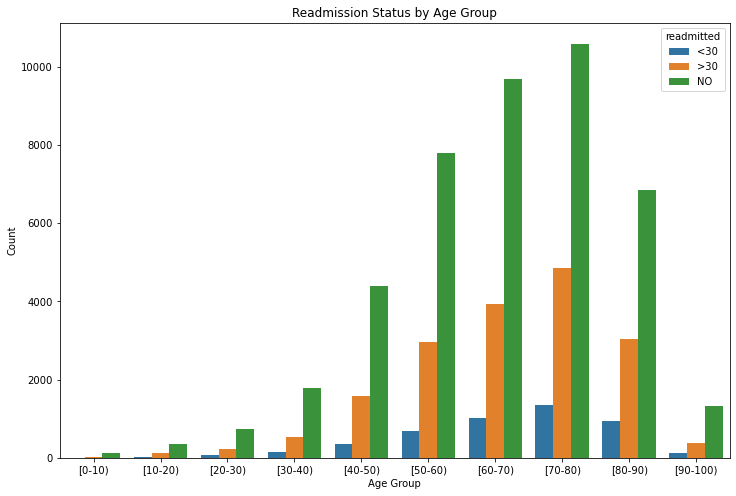

In [48]:
import seaborn as sns

#Readmission vs Age
plt.figure(figsize=(12, 8))
age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
sns.countplot(x='age', hue='readmitted', data=data, order=age_order)
plt.title('Readmission Status by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

In [49]:
#Readmission correlation with other 41 features

print(data['readmitted'].dtypes)

object


In [10]:
data['diag_1'].dtype
data['diag_1'] = pd.to_numeric(data['diag_1'],errors='coerce')

In [12]:

mean_diag_1 = data['diag_1'].mean()
data['diag_1'] = data['diag_1'].replace(to_replace=0, value=mean_diag_1)

data['diag_1']

0        276.00
1        648.00
2          8.00
3        197.00
4        414.00
          ...  
91584    250.13
91585    560.00
91586     38.00
91587    996.00
91588    530.00
Name: diag_1, Length: 91589, dtype: float64

In [13]:

data['diag_2'] = pd.to_numeric(data['diag_2'],errors='coerce')
data['diag_3'] = pd.to_numeric(data['diag_3'],errors='coerce')

In [14]:
mean_diag_2 = data['diag_2'].mean()
data['diag_2'] = data['diag_2'].replace(to_replace=0, value=mean_diag_2) 
mean_diag_3 = data['diag_3'].mean()
data['diag_3'] = data['diag_3'].replace(to_replace=0, value=mean_diag_3)

In [18]:
print(corr)

                          encounter_id  patient_nbr  admission_type_id  \
encounter_id                  1.000000     0.513147          -0.159765   
patient_nbr                   0.513147     1.000000          -0.013280   
admission_type_id            -0.159765    -0.013280           1.000000   
discharge_disposition_id     -0.133158    -0.137993           0.082166   
admission_source_id          -0.112400    -0.031882           0.106947   
time_in_hospital             -0.060710    -0.022998          -0.012517   
num_lab_procedures           -0.026486     0.015457          -0.142581   
num_procedures               -0.015324    -0.018171           0.127318   
num_medications               0.076013     0.019753           0.079461   
number_outpatient             0.104015     0.103043           0.026553   
number_emergency              0.082807     0.062133          -0.018572   
number_inpatient              0.031032     0.013405          -0.039997   
diag_1                        0.005756

In [19]:
data.columns


Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [22]:
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
2,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[50-60),2,1,2,3,31,6,16,...,No,Steady,No,No,No,No,No,No,Yes,>30
